In [1]:
import numpy as np
import pandas as pd
import os
import glob
import shutil
from osgeo import gdal
import struct
import utm
import matplotlib.pyplot as plt
import mapping_functions as kmap

plt.style.use('dark_background')

## After running the above through pix4d - checking that the output makes sense

In [2]:
video_name = 'observation088'

root_folder = '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/processed-videos/raw-footage/' + video_name 
frame_folders_root = '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/raw-frames/raw-footage/' + video_name 
drone_frame_movement_file = os.path.join(root_folder, 'drone_frame_movement.npy')

obs_name = 'ob088'
pix4d_folder = root_folder + '/map-images/whole-observation/pix4d_output/' + obs_name + '_frames'


# From pix4d

pmatrix_file = pix4d_folder + '/1_initial/params/' + obs_name + '_frames_pmatrix.txt' 
offset_file = pix4d_folder + '/1_initial/params/' + obs_name + '_frames_offset.xyz'

In [3]:
# Process the pmatrix files
pmatrix_list = kmap.create_pmatrix_dicts(pmatrix_file)
print(pmatrix_list[0].keys())


# get offset vector 
with open(offset_file) as f:
    offset_raw = f.read()
offset = np.array(offset_raw.split(' ')).astype(float)


dict_keys(['image_name', 'pmatrix', 'inv_mmatrix', 'p4'])


In [4]:
geotif_dsm_file =  pix4d_folder + '/3_dsm_ortho/1_dsm/' + obs_name + '_frames_dsm.tif' 
geotif_image_file = pix4d_folder + '/3_dsm_ortho/2_mosaic/' + obs_name + '_frames_transparent_mosaic_group1.tif' 
dsm_gtif = gdal.Open(geotif_dsm_file)
image_gtif = gdal.Open(geotif_image_file)

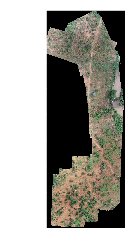

In [5]:
# Open the evevation raster from the geotiff and set all undifined values to the map average

dsm = dsm_gtif.GetRasterBand(1).ReadAsArray()
dsm_ave = np.min(dsm[dsm!= -10000])
dsm = np.where(dsm == -10000, dsm_ave, dsm)
elevation_r = dsm

bands = []
for band_num in range(1, 4):
    srcband = image_gtif.GetRasterBand(band_num)
    a = srcband.ReadAsArray()
    bands.append(a)
image_map = np.stack(bands, 2)
plt.figure()
plt.imshow(image_map)

In [12]:
# Get information for converting between utm and raster coordinates
dsm_transform = dsm_gtif.GetGeoTransform()
x_origin = dsm_transform[0]
y_origin = dsm_transform[3]
pixel_width = dsm_transform[1]
pixel_height = dsm_transform[5]

In [13]:
drone_camera_locations_file = pix4d_folder + '/1_initial/params/' + obs_name + '_frames_calibrated_external_camera_parameters_wgs84.txt' 

In [14]:
animal_tracks_file = root_folder + '/localizations/tracks-complete.npy'
animal_tracks = np.load(animal_tracks_file)

In [15]:
with open(drone_camera_locations_file, 'r') as f:
    data = f.readlines()
drone_camera_info_names = data[0].split(' ')
drone_camera_locations_unsorted = pd.DataFrame(columns=drone_camera_info_names)    
for line in data[1:]:
    drone_camera_info = line.split(' ')
    drone_camera_dict = {}
    for info_ind in range(len(drone_camera_info)):
        if info_ind == 0:
            drone_camera_dict[drone_camera_info_names[info_ind]] = drone_camera_info[info_ind]
        else:
            drone_camera_dict[drone_camera_info_names[info_ind]] = float(drone_camera_info[info_ind])
    drone_camera_locations_unsorted = drone_camera_locations_unsorted.append(drone_camera_dict, ignore_index=True)
    
# Sort the drone camera coordinates in standard image sort order
image_names = list(drone_camera_locations_unsorted['imageName'])
sort_index = [image_names.index(i) for i in sorted(image_names, key=lambda name: (name.split('_')[-2],int(name.split('.')[-2].split('_')[-1])))]
drone_camera_locations = drone_camera_locations_unsorted.iloc[sort_index].copy()
camera_lat_long = drone_camera_locations.loc[:,['latitude', 'longitude']]
camera_lat_long = camera_lat_long.reset_index(drop=True)


In [16]:
camera_lat_long.loc[0]

latitude      0.340998
longitude    36.911568
Name: 0, dtype: float64

In [17]:
# Load the saved flight logs that contain both drone sensor info and the video frame info
dataframe_folder = os.path.join(root_folder, 'drone-logs')
dataframe_files = glob.glob(dataframe_folder + '/*.pkl')
dataframe_files.sort()
flight_logs = [pd.read_pickle(file) for file in dataframe_files]
num_flights = len(flight_logs)

In [18]:
# Get an assortment of colors for plotting

from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_colors = [name for hsv, name in by_hsv]

In [19]:
list(flight_logs[2].loc[flight_logs[2]['used_in_map'], 'frame_num'])[-1]

68435

In [20]:


drone_frame_list = []
drone_frame_ind_list = []
drone_frame_file_list= []

video_frame_folders = glob.glob(frame_folders_root + '/*')
video_name_paths = [folder.rpartition('_')[0] for folder in video_frame_folders]
# get only one entry for every video name
video_name_paths = list(set(video_name_paths))
video_name_paths.sort()

# Keeps track of the frame count from the previously added videos
total_frame_count_base = 0

# Get number of frames in each video
drone_video_letters = ['A', 'B', 'C']
first_frame_count = [0]
for video_id in drone_video_letters:
    first_frame_count.append(len(glob.glob(frame_folders_root + '/*_' + video_id + '_*/*.jpg')))
print(first_frame_count)

for flight_ind in range(num_flights):
    # Frames used to make the pix4d map
    frames_this_flight = list(flight_logs[flight_ind].loc[flight_logs[flight_ind]['used_in_map'], 'frame_num'])
#     # list already has entries
#     if drone_frame_list:
#         last_frame_count = drone_frame_list[-1]
#         frames_this_flight_global_count = [frame_count + last_frame_count for frame_count in frames_this_flight]
#         drone_frame_list.extend(frames_this_flight_global_count)
#     else:
    drone_frame_list.extend(frames_this_flight)
    
    frame_names = glob.glob(video_name_paths[flight_ind] + '*/*.jpg')
    frame_names.sort(key=lambda file: (int(file.split('.')[-2].split('_')[-2]), int(file.split('.')[-2].split('_')[-1])))


    first_frame = list(flight_logs[flight_ind].loc[flight_logs[flight_ind]['observing'], 'frame_num'])[0]
    
    total_frame_count_base += first_frame_count[flight_ind]
    
    for frame_num in frames_this_flight[:]:

        frame_ind, frame_file = kmap.get_image_ind_from_frame_num(frame_num, frame_names, first_frame)
        drone_frame_ind_list.append(frame_ind + total_frame_count_base)
        drone_frame_file_list.append(frame_file)
    

[0, 30442, 31687, 28606]


In [21]:
x_ex = []
x_ap = []
y = [1,2,34]
x_ex.extend(y)
x_ap.append(y)
print(x_ex)
print(x_ap)

[1, 2, 34]
[[1, 2, 34]]


In [22]:
# Load the animal tracks

# tracks_file = '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/processed-videos/raw-footage/observation088/localizations/tracks-complete.npy' 
# animal_tracks = np.load(tracks_file)
positions = [[] for _ in range(len(drone_frame_ind_list))]
for frame_ind in range(len(drone_frame_ind_list)):
    for track_ind, track in enumerate(animal_tracks):
        try:
            positions[frame_ind].append(track['track'][drone_frame_ind_list[frame_ind] - track['first_frame'] ])
        except:
            print(frame_ind)

185
185


In [23]:
import matplotlib.image as mpimg

map_image_files =  root_folder + '/map-images/whole-observation/images'
image_files = glob.glob(map_image_files + '*/*.jpg')
image_files.sort(key=lambda file: (file.split('_')[-4], int(file.split('_')[-2]), int(file.split('.')[-2].split('_')[-1])))
images = [mpimg.imread(image_file) for image_file in image_files]


In [24]:
print(len(image_files))
print(drone_frame_ind_list[30:40])

186
[28288, 29860, 29911, 30439, 30442, 30478, 30511, 30541, 30778, 30784]


100


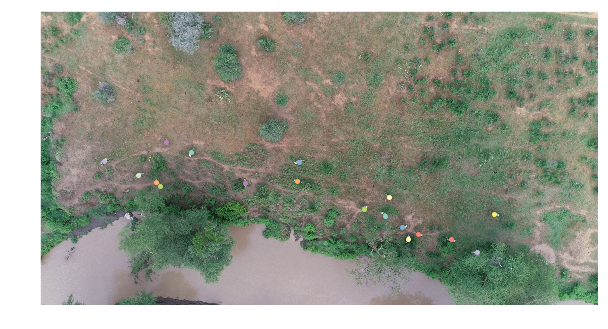

In [25]:
for image_ind in range(100,101):
    print(image_ind)
    plt.figure(figsize=(10,10))
    plt.imshow(images[image_ind])
    for position in positions[image_ind]:
        plt.scatter(position[1], images[image_ind].shape[0] - position[0], s=15)

In [26]:
animal_tracks[0].keys()

dict_keys(['last_frame', 'class_label', 'connected', 'pos_index', 'track', 'remove', 'first_frame'])

In [27]:
# map_image_files = root_folder + '/map-images/whole-observation/images' 
# image_files = glob.glob(map_image_files + '*/*.jpg')
# images = [mpimg.imread(image_file) for image_file in image_files]
demo_image = images[0]

# Create tracks in utm coordinates from tracks in drone video coordinates

max_steps = int(animal_tracks[0]['last_frame'])

first_step = True
pix4d_image_ind = 0
correct_threshold = 0.1
max_guesses = 50
z_guess = 55

for step in range(max_steps):
    if step % 5000 == 0:
        print(step)
    if drone_frame_ind_list[pix4d_image_ind + 1] <= step:
        pix4d_image_ind += 1
    matrix_dict = pmatrix_list[pix4d_image_ind]
       
    
    for track_ind, track in enumerate(animal_tracks):
        if step >= track['first_frame'] and step <= track['last_frame']:
            rel_step = step - track['first_frame']
            
            position_uv = np.array([track['track'][rel_step][1], demo_image.shape[0] - track['track'][rel_step][0]])
            x_utm, y_utm, found_point, _ = kmap.from_image_to_map(position_uv, z_guess, matrix_dict, offset, elevation_r, max_guesses, correct_threshold, pixel_width, pixel_height, x_origin, y_origin)
            utm_coords = np.array((x_utm, y_utm), ndmin=2)
            
            if first_step:
                animal_tracks[track_ind]['track_utm'] = utm_coords
            else:
                animal_tracks[track_ind]['track_utm'] = np.concatenate((animal_tracks[track_ind]['track_utm'], utm_coords))
                
    first_step = False
    
print(animal_tracks[track_ind]['track_utm'].shape)


0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
(90485, 2)


In [40]:
new_tracks_file = os.path.join(os.path.dirname(animal_tracks_file), 'tracks_with_utm.npy')
np.save(new_tracks_file, animal_tracks)
    

267509.83125000005 37785.22888


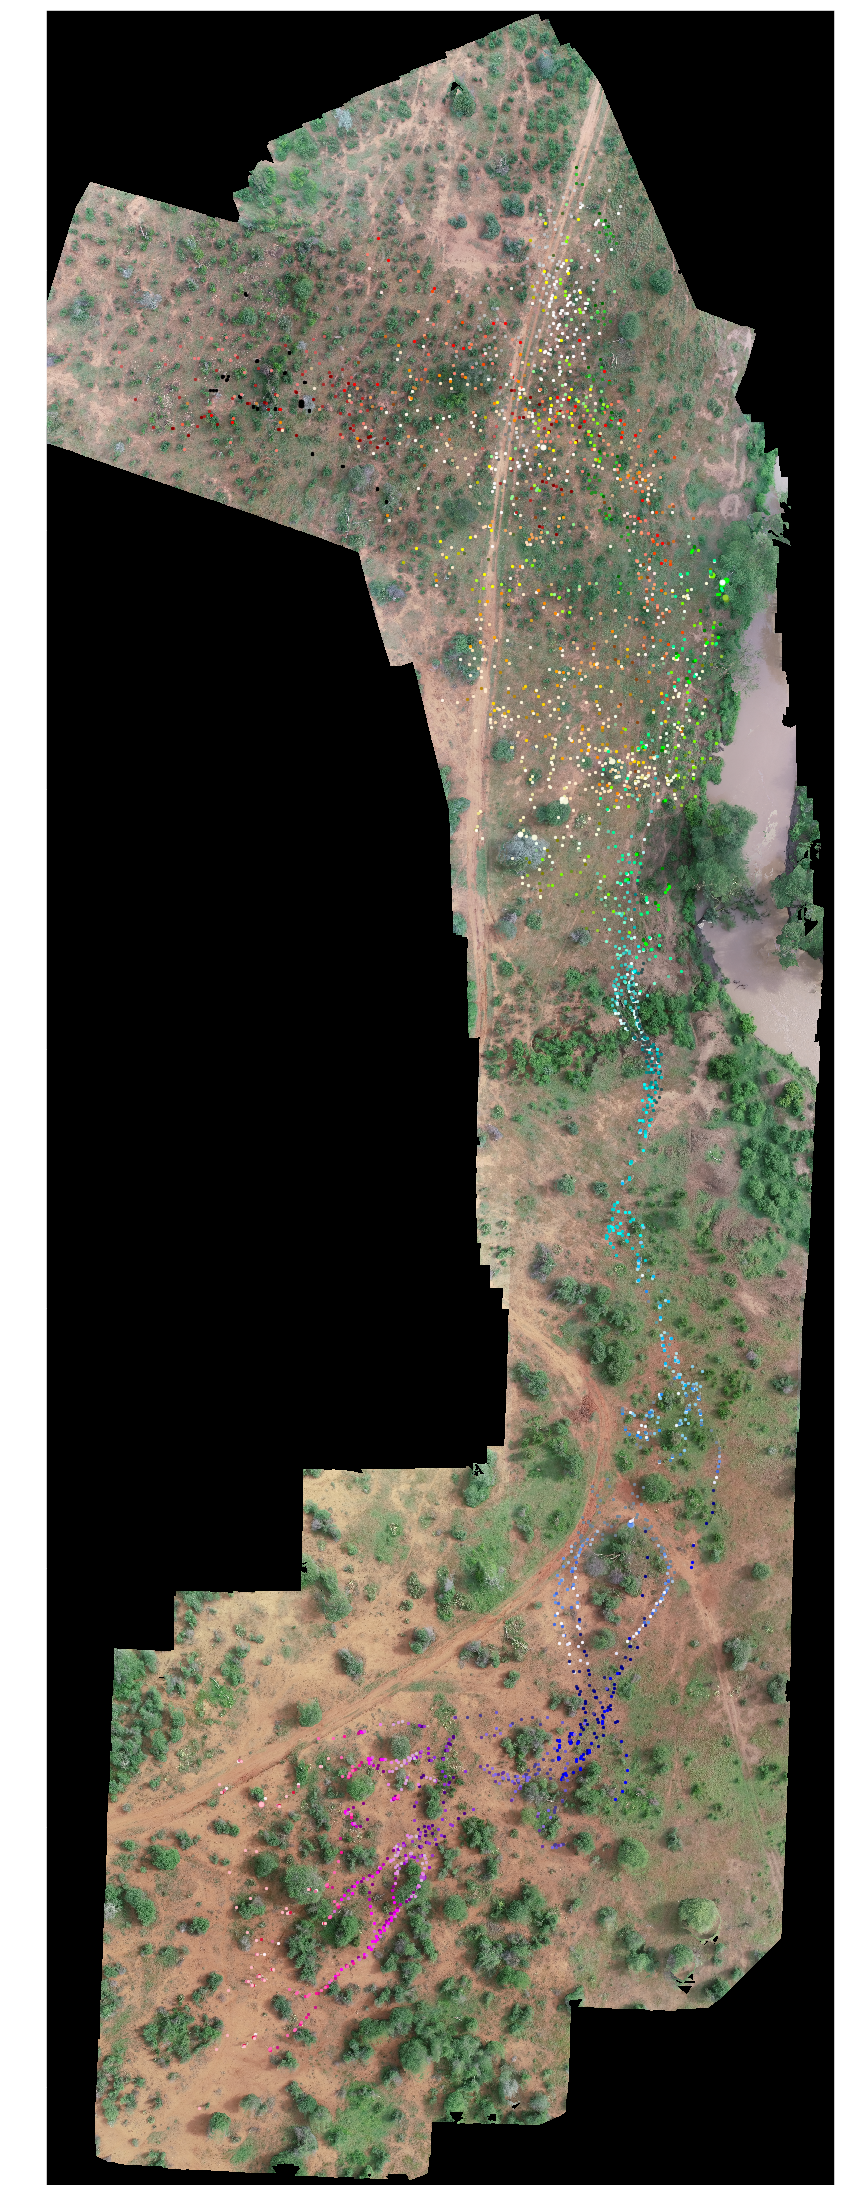

In [28]:
show = 'image_map'

plt.figure(figsize=(40,40))

if show == 'elevation':
    plt.imshow(elevation_r, vmin=elevation_r[0,0])
if show == 'image_map':
    plt.imshow(image_map)

color_inds = np.linspace(0, len(sorted_colors), camera_lat_long.shape[0] + 1).astype(int)

print(x_origin, y_origin)

# image_test_num = [0, 50, 100, 120, 150, 184]

# for point_ind in range(len(pmatrix_list)):
# #     print('point_ind', point_ind)
#     x_utm, y_utm, _, _ = utm.from_latlon(*camera_lat_long.loc[point_ind].as_matrix())
#     x_rast, y_rast = kmap.utm_to_raster(x_utm, y_utm, x_origin, y_origin, pixel_width, pixel_height, image_scale=1.0)
#     plt.scatter(x_rast, y_rast, color='blue', s=30)
    

# test = np.array([267640.14, 37730, 1625.670])

map_xyzs = [np.array([267613.14, 37689.28, 1625.811]),
            np.array([267640.14, 37730, 1621.70]),
           ]
# data = pd.DataFrame(columns=['x', 'y'])
# z_guess_center = [map_xyz[2] - 1722 for map_xyz in map_xyzs[:]]

correct_threshold = 0.1
max_guesses = 50
z_guess = 55

num_map_points = len(map_xyzs)
num_images = len(pmatrix_list)
# for map_ind in range(2):
#     map_xyz = map_xyzs[map_ind]
#     
    
#     x_rast, y_rast = kmap.utm_to_raster(map_xyz[0], map_xyz[1], x_origin, y_origin, pixel_width, pixel_height, image_scale=1.0)
#     plt.scatter(x_rast, y_rast)
#     for image_ind in range(num_images):

#         matrix_dict = pmatrix_list[image_ind]
#         uv = kmap.get_uv(map_xyz, matrix_dict['pmatrix'], offset)
#         x_utm, y_utm, found_point = kmap.from_image_to_map(uv, z_guess, matrix_dict, offset, elevation_r, max_guesses, correct_threshold, pixel_width, pixel_height, x_origin, y_origin)
#         x_rast, y_rast = kmap.utm_to_raster(x_utm, y_utm, x_origin, y_origin, pixel_width, pixel_height, image_scale=1.0)
#         if found_point:
#             point_size = 5
#         else:
#             point_size = 10
#         plt.scatter(x_rast, y_rast, color=sorted_colors[color_inds[image_ind]], s=point_size)
        
assert num_images == len(positions)

# map_image_files = '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/processed-videos/raw-footage/observation088/map_images/orig' 
# image_files = glob.glob(map_image_files + '*/*.jpg')
# images = [mpimg.imread(image_file) for image_file in image_files]
# demo_image = images[0]

# for image_ind in image_test_num:
for image_ind in range(num_images):
#     print(image_ind)
    for position in positions[image_ind]:
        matrix_dict = pmatrix_list[image_ind]
        position_uv = np.array([position[1], demo_image.shape[0] - position[0]])
        x_utm, y_utm, found_point, _ = kmap.from_image_to_map(position_uv, z_guess, matrix_dict, offset, elevation_r, max_guesses, correct_threshold, pixel_width, pixel_height, x_origin, y_origin)
        x_rast, y_rast = kmap.utm_to_raster(x_utm, y_utm, x_origin, y_origin, pixel_width, pixel_height, image_scale=1.0)
        if found_point:
            point_size = 5
        else:
            point_size = 25
#         plt.scatter(x_rast, y_rast, color=sorted_colors[color_inds[image_ind]], s=5)
        plt.scatter(x_rast, y_rast, color=sorted_colors[color_inds[image_ind]], s=point_size)
    
plt.savefig('/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/processed-videos/raw-footage/observation088/localizations/anchor_points_on_map.png',
           bbox_inches='tight', dpi=300)

<Figure size 432x288 with 0 Axes>

In [30]:
# import numpy as np
# import matplotlib
# matplotlib.use("Agg")
# import matplotlib.pyplot as plt
# import matplotlib.animation as manimation

# FFMpegWriter = manimation.writers['ffmpeg']
# metadata = dict(title='Movie Test', artist='Matplotlib',
#                 comment='Movie support!')
# writer = FFMpegWriter(fps=15, metadata=metadata)

# fig = plt.figure()
# plt.imshow(image_map)
# l, = plt.plot([], [], 'k-o')

# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

# x0, y0 = 0, 0

# with writer.saving(fig, "writer_test.mp4", 100):
#     for i in range(100):
#         x0 += 0.1 * np.random.randn()
#         y0 += 0.1 * np.random.randn()
#         l.set_data(x0, y0)
#         writer.grab_frame()

In [31]:
# Calculate uv coordinates for a given point in the map in all of the input images
image_uv = []
map_xyz = np.array([267613.14, 37689.28, 1625])
for image_ind, matrix_dict in enumerate(pmatrix_list[:]):
    uv = get_uv(map_xyz, matrix_dict['pmatrix'], offset)
#     w_est = get_w(uv, matrix_dict['inv_pmatrix'], offset, map_xyz[2])
#     for w_est in range(-40, 20, 3):
#     for w_est in range(-40, 20, 3):
#     xyz_est = get_xyz(uv, matrix_dict['inv_pmatrix'], offset)

    image_uv.append({'image_name': matrix_dict['image_name'],
                     'uv': uv})

FileNotFoundError: [Errno 2] No such file or directory: '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/processed-videos/raw-footage/observation088/map_images/APR08_2018_A_DJI_0006_4310.jpg'

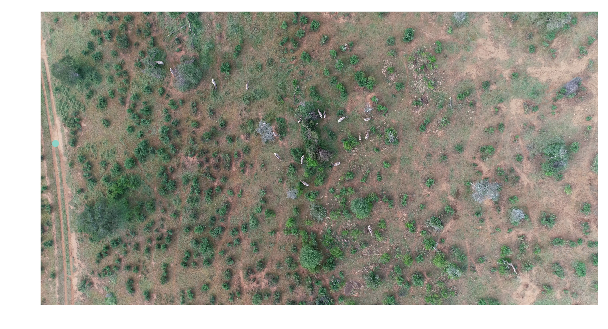

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
# Draw the calulcated uv point for each image in that image to see if it matches
image_root_file = '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/processed-videos/raw-footage/observation088/map_images' 
for image_ind, uv_dict in enumerate(image_uv):
    image_file = os.path.join(image_root_file, uv_dict['image_name'])
    image = plt.imread(image_file)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.scatter(image_uv[image_ind]['uv'][0], 
                image_uv[image_ind]['uv'][1])

## Scratch

In [19]:
frame_num = 5698
float_scale = 1000
frame_ind = np.min(np.nonzero(flight_logs[0]['frame_num'] > frame_num))
temp_df = ((flight_logs[0].loc[frame_ind-330:frame_ind, ['latitude', 'longitude', 'frame_num']] - flight_logs[0].loc[frame_ind-330, ['latitude', 'longitude', 'frame_num']]) * float_scale) ** 2
sum_df = temp_df['latitude'] + temp_df['longitude']
# print(np.sqrt(sum_df.astype(np.float64)) / float_scale)

In [11]:
focal_frame = 6246
frame_range = 3

flight_logs[0].loc[(flight_logs[0]['frame_num'] > focal_frame - frame_range) & (flight_logs[0]['frame_num'] < focal_frame + frame_range)]

latitude  longitude  altitude(feet)  ascent(feet)  speed(mph)  \
980  0.341004  36.911572     5651.195877    266.732292    0.447388   

     distance(feet)  time(millisecond)        datetime(utc)  satellites  \
980     1054.514469              99700  2018-04-08 04:54:49          18   

     voltage(v)    ...      voltageCell2  voltageCell3  voltageCell4  \
980      16.245    ...             4.096         4.092         4.097   

     voltageCell5  voltageCell6  battery_temperature(f)  flycStateRaw  \
980             0             0                   78.71             6   

     flycState  message  frame_num  
980   GPS_Atti      NaN       6247  

[1 rows x 37 columns]

In [12]:
df.loc[(df['frame_num'] > 38372 - 10) & (df['frame_num'] < 38372 + 10)]

latitude  longitude  altitude(feet)  ascent(feet)  speed(mph)  \
5937  0.339371   36.91238     5648.334434    263.779536    1.118470   
5938  0.339371   36.91238     5648.334434    263.779536    1.118470   
5939  0.339370   36.91238     5648.334434    263.779536    1.342164   

      distance(feet)  time(millisecond)        datetime(utc)  satellites  \
5937     1646.525643             620800  2018-04-08 05:36:54          20   
5938     1646.692966             620900  2018-04-08 05:36:54          20   
5939     1646.879974             621000  2018-04-08 05:36:54          20   

      voltage(v)    ...      voltageCell2  voltageCell3  voltageCell4  \
5937      15.178    ...             3.816         3.811         3.797   
5938      15.178    ...             3.816         3.811         3.797   
5939      15.178    ...             3.816         3.811         3.797   

      voltageCell5  voltageCell6  battery_temperature(f)  flycStateRaw  \
5937             0             0                  109.31             6   
5938             0             0                  109.31             6   
5939             0             0                  109.31             6   

      flycState  message  frame_num  
5937   GPS_Atti      NaN      38368  
5938   GPS_Atti      NaN      38374  
5939   GPS_Atti      NaN      38380  

[3 rows x 37 columns]

In [13]:
series = np.abs(df.loc[df.index[:-1], 'compass_heading(degrees)'].values - df.loc[1:, 'compass_heading(degrees)'].values)
len(series[series>.5])

329

In [20]:
df = flight_logs[0]
# print(df.loc[np.abs(df.loc[df.index[:-1], 'compass_heading(degrees)'].values - df.loc[1:, 'compass_heading(degrees)'].values) > .5, 'frame_num'][:])

In [15]:
print(df.loc[2:, 'compass_heading(degrees)'].values)
print(df.loc[df.index[:-2], 'compass_heading(degrees)'].values)

(df.loc[2:, 'compass_heading(degrees)'].values - df.loc[df.index[:-2], 'compass_heading(degrees)'].values)


[199.9 200.  199.9 ... 201.7 201.8 201.7]
[199.9 199.9 199.9 ... 201.7 201.7 201.7]


array([0. , 0.1, 0. , ..., 0. , 0.1, 0. ])

In [75]:
coordinates = []
for ind, log in enumerate(flight_logs[:1]):
    index = (log['frame_num'] >= first_last_frame_flights[ind]['first_frame']) & (log['frame_num'] <= first_last_frame_flights[ind]['last_frame']) 
    index = ind_list
    coordinates.append(flight_logs[ind].loc[index,'latitude':'longitude'])

In [76]:
for file_ind, file in enumerate(coordinates):
    file.to_csv(os.path.join(os.path.dirname(drone_files[file_ind]), 'lat-long-cut-{}.csv'.format(file_ind)))

In [14]:
flight_logs[0].loc[flight_logs[0].loc[:, 'isVideo'] == 1, 'isVideo']

Series([], Name: isVideo, dtype: int64)

In [17]:
flight_logs[0].loc[flight_logs[0]['isVideo'] == 1]

Empty DataFrame
Columns: [latitude, longitude, altitude(feet), ascent(feet), speed(mph), distance(feet), time(millisecond), datetime(utc), satellites, voltage(v), max_altitude(feet), max_ascent(feet), max_speed(mph), max_distance(feet), compass_heading(degrees),  pitch(degrees),  roll(degrees), isPhoto, isVideo, rc_elevator, rc_aileron, rc_throttle, rc_rudder, gimbal_heading(degrees), gimbal_pitch(degrees), battery_percent, voltageCell1, voltageCell2, voltageCell3, voltageCell4, voltageCell5, voltageCell6, battery_temperature(f), flycStateRaw, flycState, message]
Index: []

[0 rows x 36 columns]

In [18]:
image_test_num = [0, 50, 100, 120, 150, 184]
for point_ind in image_test_num:
    print('point_ind', point_ind)
    x_utm, y_utm, _, _ = utm.from_latlon(*camera_lat_long.loc[point_ind].as_matrix())
    print(x_utm, y_utm)
    

point_ind 0
267562.04696821526 37715.70948468908
point_ind 50
267624.0311093776 37660.87515772164
point_ind 100
267649.95268036495 37634.664138372864
point_ind 120
267654.9317641279 37545.39568811376
point_ind 150
267649.3349682465 37408.902723674815
point_ind 184
267556.2298291767 37363.5994348113


/home/golden/coding-py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [19]:
print(pmatrix_list[0])

{'image_name': 'APR08_2018_A_DJI_0005_6246.jpg', 'pmatrix': array([[-3.01535679e+03,  7.10827499e+02, -2.02029196e+03,
        -2.70876045e+05],
       [ 8.39579542e+02,  2.79384419e+03, -1.43649097e+03,
        -3.05284275e+05],
       [-4.93420000e-02, -9.32080000e-02, -9.94423000e-01,
         1.11600690e+01]]), 'inv_mmatrix': array([[-3.12979091e-04,  9.62069812e-05,  4.96879779e-01],
       [ 9.73468390e-05,  3.11549646e-04, -6.47820182e-01],
       [ 6.40523213e-06, -3.39754453e-05, -9.69542155e-01]]), 'p4': array([-2.70876045e+05, -3.05284275e+05,  1.11600690e+01])}


In [20]:
offset

array([267623.,  37587.,   1722.])

mu 79.4921875
mu 82.9296875
mu 82.392578125
mu 82.5
mu 81.85546875
mu 81.42578125
mu 82.71484375
mu 82.0703125
mu 82.0703125
mu 80.99609375
mu 81.42578125
mu 85.29296875
mu 85.29296875
mu 84.21875
mu 83.359375
mu 82.28515625
mu 82.0703125
mu 81.42578125


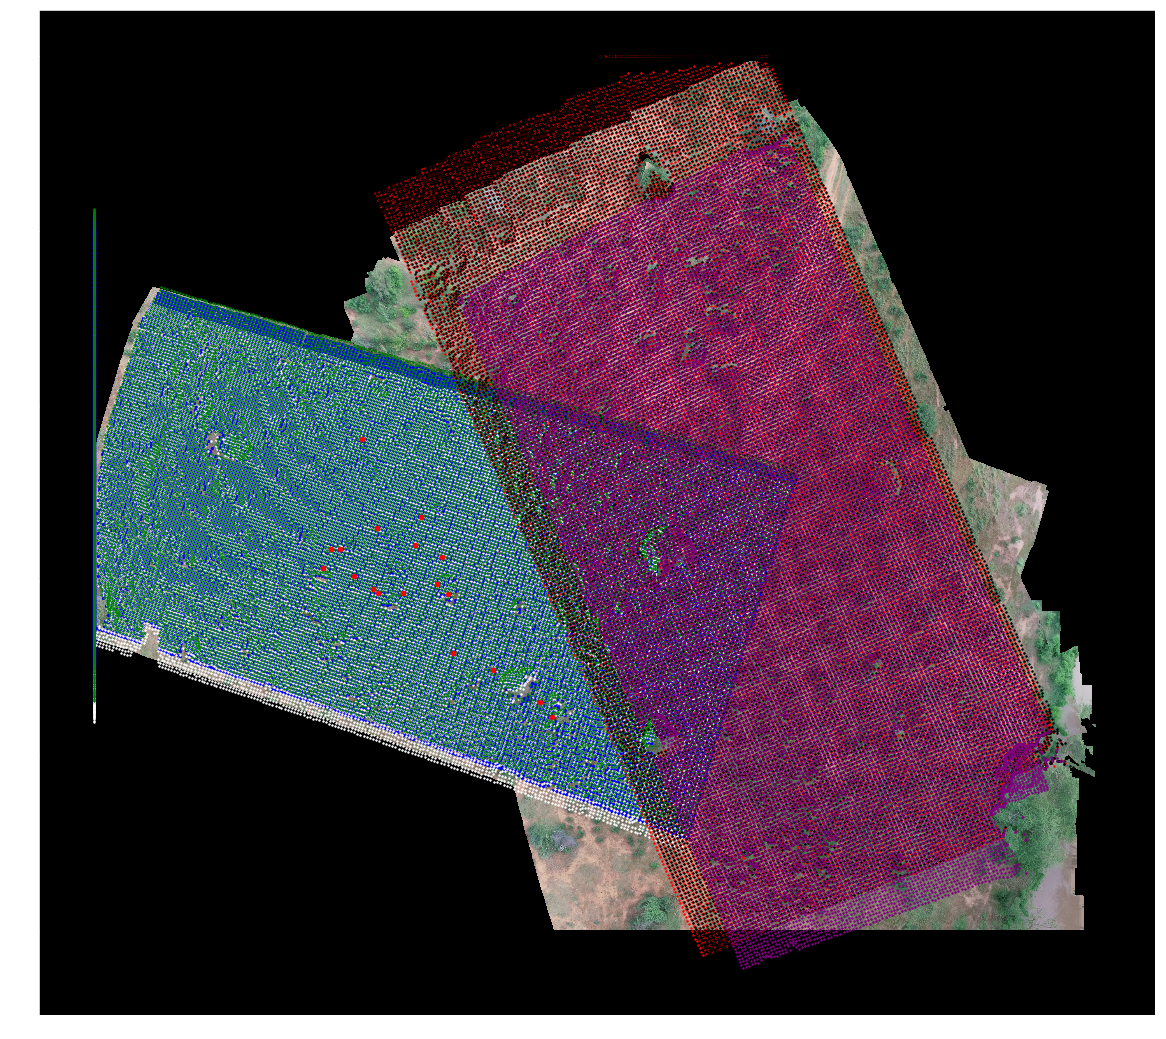

In [53]:
import copy 
x_pos = []
y_pos = []
search = 1000
width = 1080
height = 2160
image_ind = 0
plt.figure(figsize=(20,20))
plt.imshow(image_map[:5000,:])
for x in range(-width, width, 20):
    for y in range(-height, height, 20):
        xp, yp, _, _ = kmap.from_image_to_map([2160 + y, 1080 + x], 80, pmatrix_list[0], offset, elevation_r, max_guesses, correct_threshold, pixel_width, pixel_height, x_origin, y_origin)
        xp, yp = kmap.utm_to_raster(xp, yp, x_origin, y_origin, pixel_width, pixel_height, image_scale=1.0)
        x_pos.append(xp)
        y_pos.append(yp)
plt.scatter(x_pos, y_pos, s=5, color='blue')

move = 1000

# for x in range(-width+move, width+move, 20):
#     for y in range(-height+move, height+move, 20):
#         xp, yp, _ = kmap.from_image_to_map([2160 + y, 1080 + x], 80, pmatrix_list[0], offset, elevation_r, max_guesses, correct_threshold, pixel_width, pixel_height, x_origin, y_origin)
#         x_pos.append(xp)
#         y_pos.append(yp)
# plt.scatter(x_pos, y_pos, s=3, color='white')

x_pos = []
y_pos = []
p_dict = copy.deepcopy(pmatrix_list[2])
# p_dict['p4'][0] += 84 * 2048
# p_dict['p4'][1] += 84*1080
for x in range(-width, width, 20):
    for y in range(-height, height, 20):

        xp, yp, _, _ = kmap.from_image_to_map([2160 + y, 1080 + x], 80, p_dict, offset, elevation_r, max_guesses, correct_threshold, pixel_width, pixel_height, x_origin, y_origin)
        xp, yp = kmap.utm_to_raster(xp, yp, x_origin, y_origin, pixel_width, pixel_height, image_scale=1.0)
        x_pos.append(xp)
        y_pos.append(yp)
plt.scatter(x_pos, y_pos, s=2, color ='white')


x_pos = []
y_pos = []
p_dict = copy.deepcopy(pmatrix_list[3])
# p_dict['p4'][0] += 84 * 2048
# p_dict['p4'][1] += 84*1080
# p_dict['p4'][2] -= 10
for x in range(-width, width, 20):
    for y in range(-height, height, 20):

        xp, yp, _, _ = kmap.from_image_to_map([2160 + y, 1080 + x], 80, p_dict, offset, elevation_r, max_guesses, correct_threshold, pixel_width, pixel_height, x_origin, y_origin)
        xp, yp = kmap.utm_to_raster(xp, yp, x_origin, y_origin, pixel_width, pixel_height, image_scale=1.0)
        x_pos.append(xp)
        y_pos.append(yp)
plt.scatter(x_pos, y_pos, s=2, color ='red')

x_pos = []
y_pos = []
p_dict = copy.deepcopy(pmatrix_list[1])

# p_dict['p4'][1] += 84*1580
for x in range(-width, width, 20):
    for y in range(-height, height, 20):

        xp, yp, _, _ = kmap.from_image_to_map([2160 + y, 1080 + x], 80, p_dict, offset, elevation_r, max_guesses, correct_threshold, pixel_width, pixel_height, x_origin, y_origin)
        xp, yp = kmap.utm_to_raster(xp, yp, x_origin, y_origin, pixel_width, pixel_height, image_scale=1.0)
        x_pos.append(xp)
        y_pos.append(yp)
plt.scatter(x_pos, y_pos, s=2, color ='green')

x_pos = []
y_pos = []
p_dict = copy.deepcopy(pmatrix_list[4])

# p_dict['p4'][1] += 84*1580
for x in range(-width, width, 20):
    for y in range(-height, height, 20):

        xp, yp, _, _ = kmap.from_image_to_map([2160 + y, 1080 + x], 80, p_dict, offset, elevation_r, max_guesses, correct_threshold, pixel_width, pixel_height, x_origin, y_origin)
        xp, yp = kmap.utm_to_raster(xp, yp, x_origin, y_origin, pixel_width, pixel_height, image_scale=1.0)
        x_pos.append(xp)
        y_pos.append(yp)
plt.scatter(x_pos, y_pos, s=2, color ='black')
        
x_pos = []
y_pos = []
p_dict = copy.deepcopy(pmatrix_list[20])

# p_dict['p4'][1] += 84*1580
for x in range(-width, width, 20):
    for y in range(-height, height, 20):

        xp, yp, _, _ = kmap.from_image_to_map([2160 + y, 1080 + x], 80, p_dict, offset, elevation_r, max_guesses, correct_threshold, pixel_width, pixel_height, x_origin, y_origin)
        xp, yp = kmap.utm_to_raster(xp, yp, x_origin, y_origin, pixel_width, pixel_height, image_scale=1.0)
        x_pos.append(xp)
        y_pos.append(yp)
plt.scatter(x_pos, y_pos, s=2, color ='purple')    

for position in positions[image_ind]:
    matrix_dict = pmatrix_list[image_ind]
    position_uv = np.array([position[1], demo_image.shape[0] - position[0]])
    x_utm, y_utm, found_point, mu = kmap.from_image_to_map(position_uv, z_guess, matrix_dict, offset, elevation_r, max_guesses, correct_threshold, pixel_width, pixel_height, x_origin, y_origin)
    x_utm, y_utm = kmap.utm_to_raster(x_utm, y_utm, x_origin, y_origin, pixel_width, pixel_height, image_scale=1.0)
    print('mu', mu)
    plt.scatter(x_utm, y_utm, color='red', s=20)
    
# x_utm, y_utm, _, _ = utm.from_latlon(*camera_lat_long.loc[0].as_matrix())
# plt.scatter(x_utm, y_utm, color='green')

In [51]:
print(len(pmatrix_list))

186


In [80]:
np.sqrt(np.sum(np.square(np.matmul(pmatrix_list[0]['inv_mmatrix'], np.array([0,1,0])))))

0.00032783120025732727

In [81]:
np.sqrt(np.sum(np.square(np.matmul(pmatrix_list[0]['inv_mmatrix'], np.array([0,0,1])))))

1.2675064077703735

In [83]:
1000/ .00032

3124999.9999999995